<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/2_callbacks_saving_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Callbacks, saving models, and loading models with Stable Baselines

## Introduction

In this notebook, you will learn how to use *Callbacks* which allow to do monitoring, auto saving, model manipulation, progress bars, ...

You will also see the *loading* and *saving* functions, and how to read the outputed files for possible exporting.

## Install Dependencies and Stable Baselines Using Pip

In [0]:
!apt install swig
!pip install tqdm==4.36.1
!pip install stable-baselines[mpi]==2.8.0

In [0]:
import gym
from stable_baselines import A2C, SAC, PPO2, TD3

## Helper functions
This is to help the callbacks store variables (as they are function), but this could be also done by passing a class method.

In [0]:
def get_callback_vars(model, **kwargs): 
    """
    Helps store variables for the callback functions
    :param model: (BaseRLModel)
    :param **kwargs: initial values of the callback variables
    """
    # save the called attribute in the model
    if not hasattr(model, "_callback_vars"): 
        model._callback_vars = dict(**kwargs)
    else: # check all the kwargs are in the callback variables
        for (name, val) in kwargs.items():
            if name not in model._callback_vars:
                model._callback_vars[name] = val
    return model._callback_vars # return dict reference (mutable)

# Callbacks

## A functional approach
A callback function takes the `locals()` variables and the `globals()` variables from the model, then returns a boolean value for whether or not the training should continue.

Thanks to the access to the models variables, in particular `_locals["self"]`, we are able to even change the parameters of the model without halting the training, or changing the model's code.

Here we have a simple callback that can only be called twice:

In [0]:
def simple_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """ 
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], called=False) 
    
    if not callback_vars["called"]:
        print("callback - first call")
        callback_vars["called"] = True
        return True # returns True, training continues.
    else:
        print("callback - second call")
        return False # returns False, training stops.

model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1)
model.learn(8000, callback=simple_callback)

Creating environment from the given name, wrapped in a DummyVecEnv.


/home/ah257962/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


callback - first call
callback - second call


## First example: Auto saving best model
In RL, it is quite useful to keep a clean version of a model as you are training, as we can end up with burn-in of a bad policy. This is a typical use case for callback, as they can call the save function of the model, and observe the training over time.

Using the monitoring wrapper, we can save statistics of the environment, and use them to determine the mean training reward.
This allows us to save the best model while training.

Note that this is not the proper way of evaluating an RL agent, you should create an test environment and evaluate the agent performance in the callback. For simplicity, we will be using the training reward as a proxy.

In [0]:
import os

import numpy as np

from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.results_plotter import load_results, ts2xy

def auto_save_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], n_steps=0, best_mean_reward=-np.inf) 

    # skip every 500 steps
    if callback_vars["n_steps"] % 20 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])

            # New best model, you could save the agent here
            if mean_reward > callback_vars["best_mean_reward"]:
                callback_vars["best_mean_reward"] = mean_reward
                # Example for saving best model
                print("Saving new best model at {} timesteps".format(x[-1]))
                _locals['self'].save(log_dir + 'best_model')
    callback_vars["n_steps"] += 1
    return True

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('CartPole-v1')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000, callback=auto_save_callback)

## Second example: Realtime plotting of performance
While training, it is sometimes useful to how the training progresses over time, relative to the episodic reward.
For this, Stable-Baselines has [Tensorboard support](https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html), however this can be very combersome, especially in disk space usage. 

Here, we can use callback again, to plot the episodic reward in realtime, using the monitoring wrapper:

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


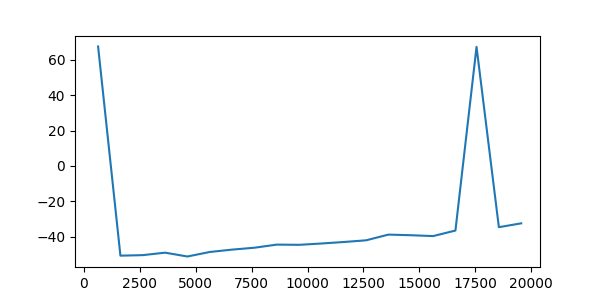

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

def plotting_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], plot=None) 
    
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    if callback_vars["plot"] is None:
        plt.ion()
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(111)
        line, = ax.plot(x, y)
        callback_vars["plot"] = (line, ax, fig)
        plt.show()
    else:
        callback_vars["plot"][0].set_data(x, y)
        callback_vars["plot"][-2].relim()
        callback_vars["plot"][-2].set_xlim([_locals["total_timesteps"] * -0.02, 
                                            _locals["total_timesteps"] * 1.02])
        callback_vars["plot"][-2].autoscale_view(True,True,True)
        callback_vars["plot"][-1].canvas.draw()
        
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('MountainCarContinuous-v0')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])
        
model = PPO2('MlpPolicy', env, verbose=0)
model.learn(20000, callback=plotting_callback)

## Third example: Progress bar
Quality of life improvement are always welcome when developping and using RL. Here, we used [tqdm](https://tqdm.github.io/) to show a progress bar of the training, along with number of timesteps per second and the estimated time remaining to the end of the training:

In [0]:
from tqdm.auto import tqdm

class progressbar_callback(object):
    def __init__(self, total_timesteps):
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self):
        self.pbar = tqdm(total=self.total_timesteps)
        
        def callback_progressbar(local_, global_):
            self.pbar.n = local_["self"].num_timesteps
            self.pbar.update(0)
            
        return callback_progressbar

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()
        
model = TD3('MlpPolicy', 'Pendulum-v0', verbose=0)
with progressbar_callback(2000) as callback: # needed for closing tqdm progress bar
    model.learn(2000, callback=callback)

## Forth example: Composition
Thanks to the functional nature of callbacks, it is possible to do a composition of callbacks, into a single callback. This means we can auto save our best model, show the progess bar and episodic reward of the training:

In [0]:
%matplotlib notebook

def compose_callback(*callback_funcs):
    def _callback(_locals, _globals):
        continue_training = True
        for cb_func in callback_funcs:
            if cb_func(_locals, _globals) is False: # as a callback can return None for legacy reasons.
                continue_training = False
        return continue_training
    return _callback

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('CartPole-v1')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

model = PPO2('MlpPolicy', env, verbose=0)
with progressbar_callback(10000) as progress_callback:
    model.learn(10000, callback=compose_callback(progress_callback, plotting_callback, auto_save_callback))

# Saving and loading

Saving and loading stable-baselines models is straightforward: you can directly call `.save()` and `.load()` on the models.

In [0]:
import os

# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model = PPO2('MlpPolicy', 'Pendulum-v0', verbose=0).learn(8000)
# The model will be saved under PPO2_tutorial.zip
model.save(save_dir + "/PPO2_tutorial")

# Check prediction before saving
print("pre saved", model.predict([0, 0, 0], deterministic=True))

del model # delete model from memory

loaded_model = PPO2.load(save_dir + "/PPO2_tutorial")
# Check that the prediction is the same after loading (for the same observation)
print("loaded", loaded_model.predict([0, 0, 0], deterministic=True))

pre saved (array([-0.0224568], dtype=float32), None)
loaded (array([-0.0224568], dtype=float32), None)


## Saving format 

The format for saving and loading models has been recently revamped as of Stable-Baselines (>2.7.0).

It is a zip-archived JSON dump and NumPy zip archive of the arrays:
```
saved_model.zip/
├── data              JSON file of class-parameters (dictionary)
├── parameter_list    JSON file of model parameters and their ordering (list)
├── parameters        Bytes from numpy.savez (a zip file of the numpy arrays). ...
    ├── ...           Being a zip-archive itself, this object can also be opened ...
        ├── ...       as a zip-archive and browsed.
```

## Save and find 

In [0]:
# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model = PPO2('MlpPolicy', 'Pendulum-v0', verbose=0).learn(8000)
model.save(save_dir + "/PPO2_tutorial")

In [0]:
!ls /tmp/gym/PPO2_tutorial*

/tmp/gym/PPO2_tutorial.zip


In [0]:
import zipfile

archive = zipfile.ZipFile("/tmp/gym/PPO2_tutorial.zip", 'r')
for f in archive.filelist:
  print(f.filename)

data
parameters
parameter_list


## Model data

In [0]:
import json
json.loads(archive.read('data'))

{'gamma': 0.99,
 'n_steps': 128,
 'vf_coef': 0.5,
 'ent_coef': 0.01,
 'max_grad_norm': 0.5,
 'learning_rate': {':type:': "<class 'function'>",
  ':serialized:': 'gASVmgEAAAAAAACMF2Nsb3VkcGlja2xlLmNsb3VkcGlja2xllIwOX2ZpbGxfZnVuY3Rpb26Uk5QoaACMD19tYWtlX3NrZWxfZnVuY5STlGgAjA1fYnVpbHRpbl90eXBllJOUjAhDb2RlVHlwZZSFlFKUKEsBSwBLAUsBSxNDBIgAUwCUToWUKYwBX5SFlIxSL2hvbWUvYWgyNTc5NjIvYW5hY29uZGEzL2xpYi9weXRob24zLjYvc2l0ZS1wYWNrYWdlcy9zdGFibGVfYmFzZWxpbmVzL3BwbzIvcHBvMi5weZSMBGZ1bmOUTSUCQwIAAZSMA3ZhbJSFlCl0lFKUSwGMGnN0YWJsZV9iYXNlbGluZXMucHBvMi5wcG8ylIeUUpR9lCiMB2dsb2JhbHOUfZSMCGRlZmF1bHRzlE6MBGRpY3SUfZSMDmNsb3N1cmVfdmFsdWVzlF2URz8wYk3S8an8YYwGbW9kdWxllGgVjARuYW1llGgPjANkb2OUTowIcXVhbG5hbWWUjBVjb25zdGZuLjxsb2NhbHM+LmZ1bmOUdXRSLg=='},
 'lam': 0.95,
 'nminibatches': 4,
 'noptepochs': 4,
 'cliprange': {':type:': "<class 'function'>",
  ':serialized:': 'gASVmgEAAAAAAACMF2Nsb3VkcGlja2xlLmNsb3VkcGlja2xllIwOX2ZpbGxfZnVuY3Rpb26Uk5QoaACMD19tYWtlX3NrZWxfZnVuY5STlGgAjA1fYnVpbHRpbl90eXBllJOUjAhDb2RlVHlwZZSFlFKU

In [0]:
json.loads(archive.read('data'))["observation_space"]

{':type:': "<class 'gym.spaces.box.Box'>",
 ':serialized:': 'gASVBAEAAAAAAACMDmd5bS5zcGFjZXMuYm94lIwDQm94lJOUKYGUfZQojANsb3eUjBVudW1weS5jb3JlLm11bHRpYXJyYXmUjAxfcmVjb25zdHJ1Y3SUk5SMBW51bXB5lIwHbmRhcnJheZSTlEsAhZRDAWKUh5RSlChLAUsDhZRoCYwFZHR5cGWUk5SMAmY0lEsASwGHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYolDDAAAgL8AAIC/AAAAwZR0lGKMBGhpZ2iUaAhoC0sAhZRoDYeUUpQoSwFLA4WUaBWJQwwAAIA/AACAPwAAAEGUdJRijAVzaGFwZZRLA4WUjAVkdHlwZZRoFXViLg==',
 'low': '[-1. -1. -8.]',
 'high': '[1. 1. 8.]',
 'shape': [3],
 'dtype': 'float32'}

In [0]:
import cloudpickle
import base64

obs_space = cloudpickle.loads(
    base64.b64decode(
        json.loads(archive.read('data'))["observation_space"][":serialized:"]
    )
)

print(obs_space, type(obs_space))
print(obs_space.__dict__)

Box(3,) <class 'gym.spaces.box.Box'>
{'low': array([-1., -1., -8.], dtype=float32), 'high': array([1., 1., 8.], dtype=float32), 'shape': (3,), 'dtype': dtype('float32')}


## Model parameters

In [0]:
json.loads(archive.read('parameter_list'))

['model/pi_fc0/w:0',
 'model/pi_fc0/b:0',
 'model/vf_fc0/w:0',
 'model/vf_fc0/b:0',
 'model/pi_fc1/w:0',
 'model/pi_fc1/b:0',
 'model/vf_fc1/w:0',
 'model/vf_fc1/b:0',
 'model/vf/w:0',
 'model/vf/b:0',
 'model/pi/w:0',
 'model/pi/b:0',
 'model/pi/logstd:0',
 'model/q/w:0',
 'model/q/b:0']

In [0]:
import io
tmp_file = io.BytesIO(archive.read('parameters'))

param_archive = zipfile.ZipFile(tmp_file, 'r')
for f in param_archive.filelist: print(f.filename) 

model/pi_fc0/w:0.npy
model/pi_fc0/b:0.npy
model/vf_fc0/w:0.npy
model/vf_fc0/b:0.npy
model/pi_fc1/w:0.npy
model/pi_fc1/b:0.npy
model/vf_fc1/w:0.npy
model/vf_fc1/b:0.npy
model/vf/w:0.npy
model/vf/b:0.npy
model/pi/w:0.npy
model/pi/b:0.npy
model/pi/logstd:0.npy
model/q/w:0.npy
model/q/b:0.npy


The numpy file of some of the weights, with the header (\x93NUMPY, 2 bytes version, 2 bytes header size, header) and with the values stored in little endian ([file format](https://numpy.org/neps/nep-0001-npy-format.html#format-specification-version-1-0) for numpy npy)

In [0]:
param_archive.read("model/pi_fc0/w:0.npy")

b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f4\', \'fortran_order\': False, \'shape\': (3, 64), }                                                         \n\xa7>\x8b=\n\xbc\xd3>M,#>\'X\xe8\xbd\x14a\x18>\xa4\xe3\xa7\xbeK\xcb\x0c\xbftLb>\x97\xb8\x8c>@t\x06\xbe\x97\xb3e\xbeC\x82J\xbdlI\xf7\xbc\xdf\xfeo\xbe\x97\xec\xbe\xbdR\x06\xd8=a\xa8\xe9\xbcFj\xb1=\xad\x06\x97\xbb\xf3B\x1c\xbd\x85+\x12<\xaa\xdc\x92\xbd\xbb\xde\x97>\xf9\x0f\x9b=y\xfeW\xbd\x9f\xbb\x9c=\xc7E\x06>\xfc"R\xbez\xce\x9a\xbe\xa1@E\xbdf\xf8\x85=\x16\xa4 =b\x1e\n\xbc\xc7\xd3\x1d<7%\x9f\xbdc\x9cc>\x94a\x19>\xb0\x8c\x06>\x97\x81\xcb>\xfa\x18\xdd\xbc\xaf+\xbd>\x80\x8ai>`\x81U>\xd4\t\x7f\xbe#_\xd6;Ak\x1f\xbe\xa0\xe7V\xbd\x11R\x03>2\xad~;\xa8\xec(>-\x98O\xbdV\xc8h\xbd\xce\xd8:>\xa7\xf8\x04\xbe\xd2\xde\x97<\x06\xe3\xae\xbd\xe27\xbb=\xc4\x1f\xf6=e\xf6\x06>\xd8\xbe\x94=\xb4W\x9e\xbdg\xbfB\xbe\xa4I\xfe\xbdg\xcf\xd7<\x9a&\x03>\x06w(\xbe\x9f\xe3\xe3\xbel&\x85=\xb4\xfe\x00<2\x1a<\xbeK\xd5\xe1\xbd\xc5\x99t=\xd7\xef5\xbe\xabB\x9e\xbe\xea\xe1\x9d>Jk

In [0]:
tmp_file = io.BytesIO(param_archive.read("model/pi_fc0/w:0.npy"))

np.load(tmp_file)

array([[ 0.06799059,  0.413544  ,  0.15934868, -0.11344939,  0.14880782,
        -0.32790864, -0.549977  ,  0.22099477,  0.2748458 , -0.13130283,
        -0.2243179 , -0.04944063, -0.03018638, -0.2343707 , -0.0932247 ,
         0.10548081, -0.02852267,  0.08662848, -0.00460895, -0.03814979,
         0.00892151, -0.07170995,  0.29662117,  0.07571406, -0.05273292,
         0.07652973,  0.13112555, -0.20521158, -0.30235654, -0.04815734,
         0.06541519,  0.03921898, -0.0084301 ,  0.00963301, -0.0777077 ,
         0.22227626,  0.1497863 ,  0.13139606,  0.39747307, -0.02698945,
         0.3694739 ,  0.2280674 ,  0.20850134, -0.24906093,  0.0065421 ,
        -0.15568258, -0.05246699,  0.12824275,  0.00388606,  0.16496527,
        -0.05068224, -0.05683168,  0.18246767, -0.12985478,  0.01853887,
        -0.08539395,  0.09141518,  0.12017778,  0.1317993 ,  0.07262963,
        -0.07731572, -0.19018327, -0.1241639 ,  0.02634401],
       [ 0.12807694, -0.16451654, -0.445096  ,  0.06501469,  0.

## Exporting saved models

And finally some futher reading for those who want to export to tensorflowJS or Java.

https://stable-baselines.readthedocs.io/en/master/guide/export.html